# Gaussian mean estimation with performative effects

This notebook implements the synthetic example presented in Section 4.1.
    
---
**Setup:** 

We consider the task of estimating the mean of a Gaussian random variable, under performative effects. 
That is, the mean of the random variable depends on the deployed classifier. The distribution map is given as

$\mathcal D(\theta)=\mathcal N (\mu+\epsilon \theta, \sigma^2)$

For training we consider the expected squared loss. For additional details we refer to the paper.

---


## Setting up experiments

 #### i) Load relevant libraries for simulation and plotting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

%matplotlib inline

 #### ii) Defining problem parameters

In [2]:
# simulation parameters
num_time_steps  = 50001

# problem parameters (square loss)
gamma = 1.0
beta  = 1.0
L     = 1.0

# define sensitivity parameters to simulate
eps = 0.9

# base distribution
mu = 10
sigma = 0.1

# performatively stable point
mu_PS = mu / (1.0-eps)

# number of repetitions for each experiment
num_rep = 20

#### iii) Defining SGD strategies 

we implement the following strategies:

- greedy deploy
- lazy deploy with $n(k)=k$
- lazy deploy with $n(k)=k^2$
- lazy deploy with $n(k)=\sqrt{k}$

In [3]:
# strategies we consider
runs = ['SGD-greedy','SGD-lazy-rootk','SGD-lazy','SGD-lazy-ksquare']

# define legend entries
names = {}
names['SGD-greedy']       = 'greedy deploy'
names['SGD-lazy-rootk']   = r'lazy deploy, $n(k) = \sqrt{k}$'
names['SGD-lazy']         = r'lazy deploy, $n(k) = k$'
names['SGD-lazy-ksquare'] = r'lazy deploy, $n(k) = k^2$'

#### iv) Defining sequence of deployment times for each strategy

In [4]:
# define deployment times for different strategies
deployment_times = {}

for run in runs:
    
    # base distribution D0 which has been deployed far in the past
    k = 0
    deployment_times[run] = [-1]

    # deploy first classifier at t=0 to start optimization
    t_next = 0

    # pre-determine depolyment_times
    for t in range(num_time_steps):

        #deploy the ERM classifier of D0 at the first step
        if t == t_next:

            deployment_times[run].append(t)
            k = k + 1    

            # deploy every step
            if run == 'SGD-greedy':
                n_steps = 1

            # lazy schedules
            elif run == 'SGD-lazy':
                n_steps = k

            elif run == 'SGD-lazy-ksquare':
                n_steps = k**2

            elif run == 'SGD-lazy-rootk':
                n_steps = max(1,np.ceil(np.sqrt(k)))

            else:
                print('no matching schedule found')

            t_next = t + n_steps


visualize deployment times

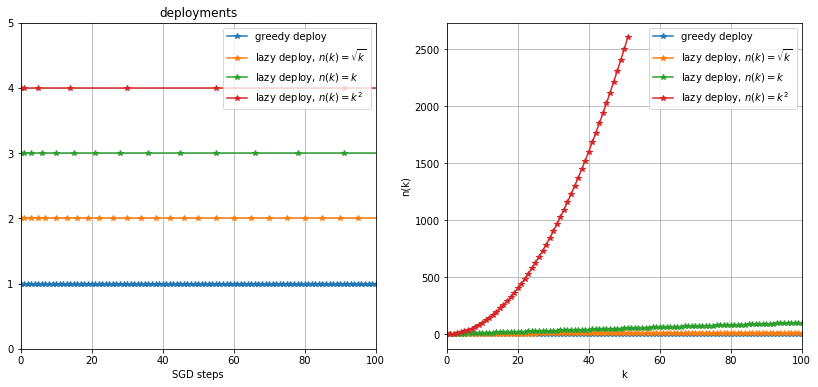

In [5]:
# visualize deployment schedule
fig = plt.figure(figsize=(14,6)) 
plt.subplot(1, 2, 1)
plt.title('deployments')

c=0
for run in runs:
    c= c+1
    vals = np.array(deployment_times[run])    
    plt.plot(vals,np.ones(len(vals))*c,'-*', label = names[run])
            

plt.legend()
plt.ylim([0,c+1])
plt.xlim([0,100])
plt.xlabel('SGD steps')
plt.grid()

# visualize deployment schedule
plt.subplot(1, 2, 2)

c=0
for run in runs:
    c= c+1  
    vals = np.array(deployment_times[run])[1:-1]-np.array(deployment_times[run])[0:-2]  
    plt.plot(vals,'-*', label = names[run])
            
plt.legend()
plt.xlim([0,100])
plt.xlabel('k')
plt.ylabel('n(k)')
plt.grid()

## Simulations with performativity

#### i) simulate training for different SGD strategies

In [ ]:
print('total number of experiments: {}'.format(len(runs)))
print('running experiment: ',end='')

count_run = 1
theta_init = mu  

record_theta           = {}
record_theta_deployed  = {}

for run in runs:
    print('{} '.format(count_run),end='')
    
    # recording deployed theta and theta iterates
    record_theta[run]          = np.zeros([num_rep, num_time_steps])
    record_theta_deployed[run] = np.zeros([num_rep, num_time_steps])

    # print progress
    count_run = count_run+1

    num_deployments = len(deployment_times[run])

    # repeate
    for rep in range(num_rep):       

        # initialize local parameter vectors
        theta_deployed    = np.zeros(num_deployments+1)
        mixture_weights   = np.zeros(num_deployments+1)

        # initialize training
        theta              = theta_init

        # D0
        theta_deployed[0]  = 0
        mixture_weights[0] = 1.0

        # deployed at time step 0
        k = 0
        t_local = 1

        # total time count
        for t in range(num_time_steps):

            if t == 0:

                # initial classifiers
                record_theta[run][rep,t]          = theta
                record_theta_deployed[run][rep,t] = 0

                theta_deployed[1] = theta
                k = 1
                t_local = 1

                # heuristic
                t_next = 1
                continue


            # mean of this mixture component
            this_mu = mu + eps * theta_deployed[k]

            # random sample
            s = np.random.normal(this_mu, sigma, 1)[0]   

            # local stepsize schedule
            if run == 'SGD-lazy' or run == 'SGD-lazy-rootk' or run == 'SGD-lazy-ksquare':
                stepsize = 1.0 / gamma / (8 * L**2 /gamma**2 + t_local) 

            elif run == 'SGD-greedy':
                stepsize = 1.0 / (gamma - beta * eps) / (8 * L**2 /(gamma - eps * beta)**2 + t)

            else:
                stepsize = 0
                print('no matching configureation found')

            theta = theta + stepsize * (s-theta)

            t_local = t_local + 1        

            if t in deployment_times[run]:

                # deploy classifier for next round
                theta_deployed[k+1] = theta

                # increment deployment
                k = k+1
                t_local = 1


            # record state of current step
            record_theta[run][rep,t]          = theta
            record_theta_deployed[run][rep,t] = theta_deployed[k-1]




total number of experiments: 4
running experiment: 1 

#### ii) visualize convergence during training

In [ ]:
# visualization with 90% confidence interval
z = 1.645

a) convergence as a function of time

In [ ]:
# plot distance to stable point over time
fig = plt.figure(figsize=(12,6)) 

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# comparison greedy vs lazy
plt.subplot(1,2,1)
runs_to_plot = ['SGD-greedy','SGD-lazy']

ax = plt.gca()
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax.set_xticklabels(['0','10k','20k','30k','40k','50k'])

for c_r,run in enumerate(runs_to_plot):
    
    legend_entry = names[run]
    vals      = np.abs(record_theta_deployed[run]-mu_PS)

    avg_val = np.mean(vals, axis=0)
    std_val = np.std(vals, axis=0)

    # confidence intervals
    lb = avg_val - z*std_val/np.sqrt(num_rep)
    ub = avg_val + z*std_val/np.sqrt(num_rep)

    plt.plot(avg_val, label = legend_entry, color = colors[c_r%10])
    plt.fill_between(range(len(lb)),lb, ub, color = colors[c_r], alpha=.2)

plt.plot(0,avg_val[0], marker = '*', color = colors[0], ms=15)

plt.title('eps={}'.format(eps))
plt.xlabel('number of samples collected',fontsize = 15)
plt.ylabel('distance to stable point',fontsize = 15)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yscale('log')
plt.grid()



# comparison lazy with different deployment schedules
plt.subplot(1,2,2) 
runs_to_plot = ['SGD-lazy-rootk','SGD-lazy','SGD-lazy-ksquare']

ax = plt.gca()
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax.set_xticklabels(['0','10k','20k','30k','40k','50k'])

for c_r,run in enumerate(runs_to_plot):
    
    legend_entry = names[run]
    
    vals = np.abs(record_theta_deployed[run]-mu_PS)

    avg_val = np.mean(vals, axis=0)
    std_val = np.std(vals, axis=0)

    # confidence intervals
    lb = avg_val - z*std_val/np.sqrt(num_rep)
    ub = avg_val + z*std_val/np.sqrt(num_rep)

    plt.plot(avg_val, label = legend_entry, color = colors[c_r%10])
    plt.fill_between(range(len(lb)),lb, ub, color = colors[c_r], alpha=.2)
    

plt.plot(0,avg_val[0], marker = '*', color = colors[0], ms=15)

plt.title('eps={}'.format(eps))
plt.xlabel('number of samples collected',fontsize = 15)
plt.ylabel('distance to stable point',fontsize = 15)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yscale('log')
plt.grid()


b) convergence as a function of the number of deployments

In [ ]:
# plot suboptimality as a fucntion of deployments
fig = plt.figure(figsize=(4,4)) 

for c_r,run in enumerate(runs):
    
    x_vals = deployment_times[run]

    legend_entry = names[run]
    
    vals = np.abs(record_theta_deployed[run]-mu_PS)[:,x_vals]

    avg_val = np.mean(vals, axis=0)
    std_val = np.std(vals, axis=0)
    
    # confidence intervals
    lb = avg_val - z*std_val/np.sqrt(num_rep)
    ub = avg_val + z*std_val/np.sqrt(num_rep)

    plt.plot(avg_val, label = legend_entry, color = colors[c_r%10])
    plt.fill_between(range(len(lb)),lb, ub, color = colors[c_r], alpha=.2)
    
    plt.plot(len(avg_val),avg_val[-1], marker = '*', color = colors[c_r], ms=15)


plt.legend(fontsize = 12, loc = 'upper right')

plt.title('eps={}'.format(eps))
plt.xscale('log')
plt.xlabel('number of deployments',fontsize = 15)
plt.ylabel('distance to stable point',fontsize = 15)
plt.yscale('log')
plt.grid()
plt.ylim([0.001,100000])